# Backup Coverage Location Problem: An Empirical Example

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

This tutorial extends the [Empirical examples](./facloc-real-world.ipynb) notebook, specifically for the Backup Coverage Location Set Covering Problem (LSCP-B). A deeper dive into the LSCP-B can be found [here](./lscpb.ipynb).
Also, this tutorial demonstrates the use of different solvers that [PULP](https://github.com/coin-or/pulp) supports.

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2023-12-10T13:40:53.251480-05:00

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 8.18.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 23.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import pandas
import pulp
import shapely
from shapely.geometry import Point
import spopt
from spopt.locate import LSCP, LSCPB
import time
import warnings

%watermark -w
%watermark -iv

Watermark: 2.4.3

pulp               : 2.7.0
spopt              : 0.5.1.dev53+g5cadae7
geopandas          : 0.14.1
pandas             : 2.1.3
shapely            : 2.0.2
matplotlib         : 3.8.2
matplotlib_scalebar: 0.8.1



-------------------
We use 4 data files as input:

- `network_distance` is the distance between facility candidate sites calculated by ArcGIS Network Analyst Extension
- `demand_points` represents the demand points with some important features for the facility location problem like population
- `facility_points` represents the stores that are candidate facility sites
- `tract` is the polygon of census tract 205.

All datasets are online on this [repository](https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store).

In [3]:
DIRPATH = "../spopt/tests/data/"

`network_distance` dataframe

In [4]:
network_distance = pandas.read_csv(
    DIRPATH + "SF_network_distance_candidateStore_16_censusTract_205_new.csv"
)
network_distance

,distance,name,DestinationName,demand
0,671.573346,Store_1,60750479.01,6540
1,1333.708063,Store_1,60750479.02,3539
2,1656.188884,Store_1,60750352.02,4436
3,1783.006047,Store_1,60750602.00,231
4,1790.950612,Store_1,60750478.00,7787
...,...,...,...,...
3275,19643.307257,Store_19,60816023.00,3204
3276,20245.369594,Store_19,60816029.00,4135
3277,20290.986235,Store_19,60816026.00,7887
3278,20875.680521,Store_19,60816025.00,5146


`demand_points` dataframe

In [5]:
demand_points = pandas.read_csv(
    DIRPATH + "SF_demand_205_centroid_uniform_weight.csv", index_col=0
)
demand_points = demand_points.reset_index(drop=True)
demand_points

,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat
0,1,6081602900,60816029.00,California,0.48627,4135,1679,1715,112,-122.488653,37.650807
1,2,6081602800,60816028.00,California,0.47478,4831,1484,1506,59,-122.483550,37.659998
2,3,6081601700,60816017.00,California,0.46393,4155,1294,1313,55,-122.456484,37.663272
3,4,6081601900,60816019.00,California,0.81907,9041,3273,3330,118,-122.434247,37.662385
4,5,6081602500,60816025.00,California,0.46603,5146,1459,1467,44,-122.451187,37.640219
...,...,...,...,...,...,...,...,...,...,...,...
200,204,6075011100,60750111.00,California,0.09466,5559,2930,3037,362,-122.418479,37.791082
201,205,6075012200,60750122.00,California,0.07211,7035,3862,4074,272,-122.417237,37.785728
202,206,6075017601,60750176.01,California,0.24306,5756,2437,2556,943,-122.410115,37.779459
203,207,6075017800,60750178.00,California,0.27882,5829,3115,3231,807,-122.405411,37.778934


`facility_points` dataframe

In [6]:
facility_points = pandas.read_csv(DIRPATH + "SF_store_site_16_longlat.csv", index_col=0)
facility_points = facility_points.reset_index(drop=True)
facility_points

,OBJECTID,NAME,long,lat
0,1,Store_1,-122.510018,37.772364
1,2,Store_2,-122.488873,37.753764
2,3,Store_3,-122.464927,37.774727
3,4,Store_4,-122.473945,37.743164
4,5,Store_5,-122.449291,37.731545
5,6,Store_6,-122.491745,37.649309
6,7,Store_7,-122.483182,37.701109
7,8,Store_11,-122.433782,37.655364
8,9,Store_12,-122.438982,37.719236
9,10,Store_13,-122.440218,37.745382


`study_area` dataframe

In [7]:
study_area = geopandas.read_file(DIRPATH + "ServiceAreas_4.shp").dissolve()
study_area

,geometry
0,"POLYGON ((-122.45299 37.63898, -122.45415 37.6..."


Plot `study_area`

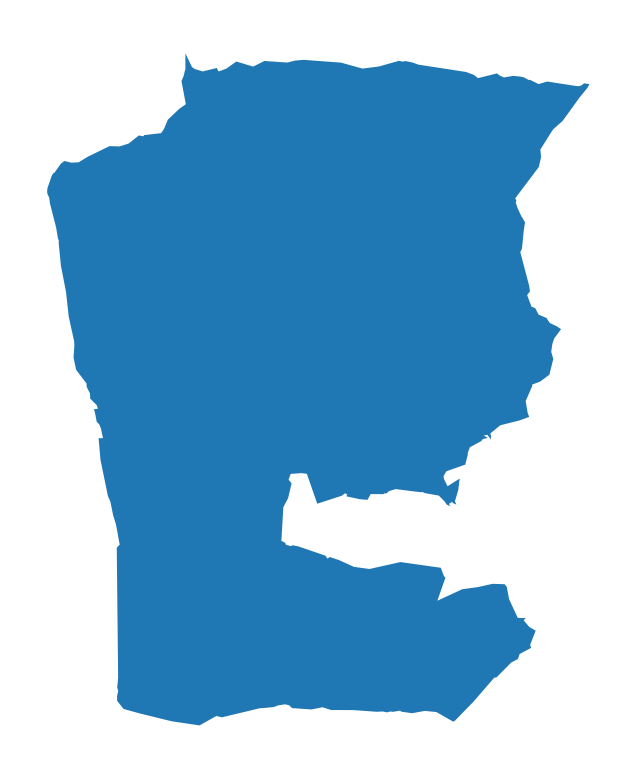

In [8]:
base = study_area.plot()
base.axis("off");

To start modeling the problem assuming the arguments expected by `spopt.locate`, we should pass a `numpy` 2D array as a cost matrix. So, first we pivot the network_distance dataframe. 

_Note that the columns and rows are sorted in ascending order._

In [9]:
ntw_dist_piv = network_distance.pivot_table(
    values="distance", index="DestinationName", columns="name"
)
ntw_dist_piv

name,Store_1,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7
DestinationName,,,,,,,,,,,,,,,,
60750101.0,11495.190454,20022.666503,10654.593733,8232.543149,7561.399789,4139.772198,4805.805279,2055.530234,225.609240,1757.623456,11522.519829,7529.985950,10847.234951,10604.729605,20970.277793,15242.989416
60750102.0,10436.169910,19392.094770,10024.022001,7601.971416,6930.828057,3093.851654,4175.233547,1257.809690,1041.911304,2333.244000,10509.099285,6470.965406,10216.663219,9974.157873,20339.706061,14612.417684
60750103.0,10746.296811,19404.672860,10036.600090,7614.549505,6943.406146,3381.778555,4187.811636,2046.436590,744.584403,1685.517099,10800.926186,6778.892307,10229.241308,9986.735962,20352.284150,14624.995773
60750104.0,11420.492134,19808.368182,10440.295413,8018.244828,7347.101469,4044.473877,4591.506959,2463.736278,795.715285,1282.217412,11308.221508,7447.187630,10632.936630,10390.431285,20755.979472,15028.691095
60750105.0,11379.443952,19583.920000,10215.847231,7793.796646,7122.653287,4103.725695,4367.058776,3320.283731,1731.462738,249.669959,11083.773326,7379.539448,10408.488448,10165.983103,20531.531290,14804.242913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60816025.0,17324.066610,2722.031291,10884.063331,14178.007937,13891.857275,18418.384867,16726.951785,20834.395022,21441.247824,20875.680521,14662.484617,16569.371114,12483.322114,11926.727459,4968.842581,8648.054204
60816026.0,15981.172325,3647.137006,10299.369046,13593.313651,13307.162990,17833.690581,16142.257500,20249.700736,20856.553539,20290.986235,14050.290332,15963.776829,11871.527828,11342.033174,3625.948296,7919.659919
60816027.0,14835.342712,4581.333336,9637.139433,12931.084039,12644.933377,17171.460969,15480.027887,19587.471124,20194.323926,19628.756623,13341.313338,15301.547216,11209.298215,10679.803561,2290.818683,7242.830306


Here the pivot table is transformed to numpy 2D array such as `spopt.locate` expected. The matrix has a shape of 205x16.

In [10]:
cost_matrix = ntw_dist_piv.to_numpy()
cost_matrix.shape

(205, 16)

In [11]:
cost_matrix[:3, :3]

array([[11495.19045438, 20022.66650296, 10654.59373325],
       [10436.16991032, 19392.09477041, 10024.0220007 ],
       [10746.29681106, 19404.67285964, 10036.60008993]])

Now, as the rows and columns of our cost matrix are sorted, we have to sort our facility points and demand points geodataframes, too. 

In [12]:
n_dem_pnts = demand_points.shape[0]
n_fac_pnts = facility_points.shape[0]

In [13]:
process = lambda df: as_gdf(df).sort_values(by=["NAME"]).reset_index(drop=True)
as_gdf = lambda df: geopandas.GeoDataFrame(df, geometry=pnts(df))
pnts = lambda df: geopandas.points_from_xy(df.long, df.lat)

In [14]:
facility_points = process(facility_points)
demand_points = process(demand_points)

Reproject the input spatial data.

In [15]:
for _df in [facility_points, demand_points, study_area]:
    _df.set_crs("EPSG:4326", inplace=True)
    _df.to_crs("EPSG:7131", inplace=True)

Set parameter `SERVICE_RADIUS` for maximum service standard of distance or time.

In [16]:
# maximum service radius (in meters)
SERVICE_RADIUS = 8000

In [17]:
solver = pulp.PULP_CBC_CMD(msg=False)

## LSCP & LSCP-B considering all candidate facilities

In [18]:
lscp = LSCP.from_cost_matrix(cost_matrix, SERVICE_RADIUS)
lscp = lscp.solve(solver)

In [19]:
lscpb = LSCPB.from_cost_matrix(cost_matrix, SERVICE_RADIUS, solver)
lscpb = lscpb.solve()

In [20]:
lscp_obj = lscp.problem.objective.value()
lscpb_obj = lscpb.problem.objective.value()
lscpb_lscp = lscpb.lscp_obj_value
lscpb_perc = round(lscpb.backup_perc, 3)
print(
    "The minimum number of facilites needed to achieve complete "
    f"coverage within a distance units service radius of {SERVICE_RADIUS} "
    f"are {lscp_obj} and {lscpb_lscp} for the LSCP and LSCP-B, "
    "respectively. However, with the LSCP-B we observe coverage by more "
    f"than one facility at {lscpb_perc}% of client locations."
)

The minimum number of facilites needed to achieve complete coverage within a distance units service radius of 8000 are 3.0 and 3.0 for the LSCP and LSCP-B, respectively. However, with the LSCP-B we observe coverage by more than one facility at 69.756% of client locations.


Define the decision variable names used for mapping later.

In [21]:
facility_points["dv"] = lscpb.fac_vars
facility_points["dv"] = facility_points["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facility_points

,OBJECTID,NAME,long,lat,geometry,dv
0,1,Store_1,-122.510018,37.772364,POINT (42712.165 26483.898),y0
1,8,Store_11,-122.433782,37.655364,POINT (49431.133 13496.279),y1
2,9,Store_12,-122.438982,37.719236,POINT (48971.439 20585.532),y2
3,10,Store_13,-122.440218,37.745382,POINT (48862.129 23487.462),y3
4,11,Store_14,-122.421636,37.742964,POINT (50499.936 23219.396),y4
5,12,Store_15,-122.430982,37.782964,POINT (49675.336 27658.898),y5
6,13,Store_16,-122.426873,37.769291,POINT (50037.687 26141.402),y6
7,14,Store_17,-122.432345,37.805218,POINT (49554.745 30128.981),y7
8,15,Store_18,-122.412818,37.805745,POINT (51274.389 30188.010),y8
9,16,Store_19,-122.398909,37.797073,POINT (52499.809 29225.972),y9


---------------------------------

## LSCP & LSCP-B with selection of predefined candidate facilities
However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define facilites $y_{11}$ and $y_{15}$ as already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

***Important:*** The facilities in `"predefined_loc"` are a binary array where `1` means the associated location must appear in the solution.

In [22]:
facility_points["predefined_loc"] = 0
facility_points.loc[(11, 15), "predefined_loc"] = 1
facility_points

,OBJECTID,NAME,long,lat,geometry,dv,predefined_loc
0,1,Store_1,-122.510018,37.772364,POINT (42712.165 26483.898),y0,0
1,8,Store_11,-122.433782,37.655364,POINT (49431.133 13496.279),y1,0
2,9,Store_12,-122.438982,37.719236,POINT (48971.439 20585.532),y2,0
3,10,Store_13,-122.440218,37.745382,POINT (48862.129 23487.462),y3,0
4,11,Store_14,-122.421636,37.742964,POINT (50499.936 23219.396),y4,0
5,12,Store_15,-122.430982,37.782964,POINT (49675.336 27658.898),y5,0
6,13,Store_16,-122.426873,37.769291,POINT (50037.687 26141.402),y6,0
7,14,Store_17,-122.432345,37.805218,POINT (49554.745 30128.981),y7,0
8,15,Store_18,-122.412818,37.805745,POINT (51274.389 30188.010),y8,0
9,16,Store_19,-122.398909,37.797073,POINT (52499.809 29225.972),y9,0


In [23]:
lscp_pre = LSCP.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    predefined_facilities_arr=facility_points["predefined_loc"].values,
    name=f"lscp-predefined",
)
lscp_pre = lscp_pre.solve(solver)

In [24]:
lscpb_pre = LSCPB.from_cost_matrix(
    cost_matrix,
    SERVICE_RADIUS,
    solver=solver,
    predefined_facilities_arr=facility_points["predefined_loc"].values,
    name=f"lscp-b-predefined",
)
lscpb_pre = lscpb_pre.solve()

In [25]:
lscp_obj = lscp_pre.problem.objective.value()
lscpb_obj = lscpb_pre.problem.objective.value()
lscpb_lscp = lscpb_pre.lscp_obj_value
lscpb_perc = round(lscpb_pre.backup_perc, 3)
print(
    "The minimum number of facilites needed to achieve complete "
    f"coverage within a distance units service radius of {SERVICE_RADIUS} "
    f"are {lscp_obj} and {lscpb_lscp} for the LSCP and LSCP-B, "
    "respectively. However, with the LSCP-B we observe coverage by more "
    f"than one facility at {lscpb_perc}% of client locations."
)

The minimum number of facilites needed to achieve complete coverage within a distance units service radius of 8000 are 4.0 and 4.0 for the LSCP and LSCP-B, respectively. However, with the LSCP-B we observe coverage by more than one facility at 87.805% of client locations.


## Plotting the results

In [26]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [27]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 9))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=0.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements = [_patch]

    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("mclp"):
            c = "k"
            if model.n_cli_uncov:
                idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                clis.iloc[idx].plot(**pnt_kws)
            _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
            _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
            legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="brown", markeredgecolor="brown")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

-------------------------

## LSCP considering all candidate facilities

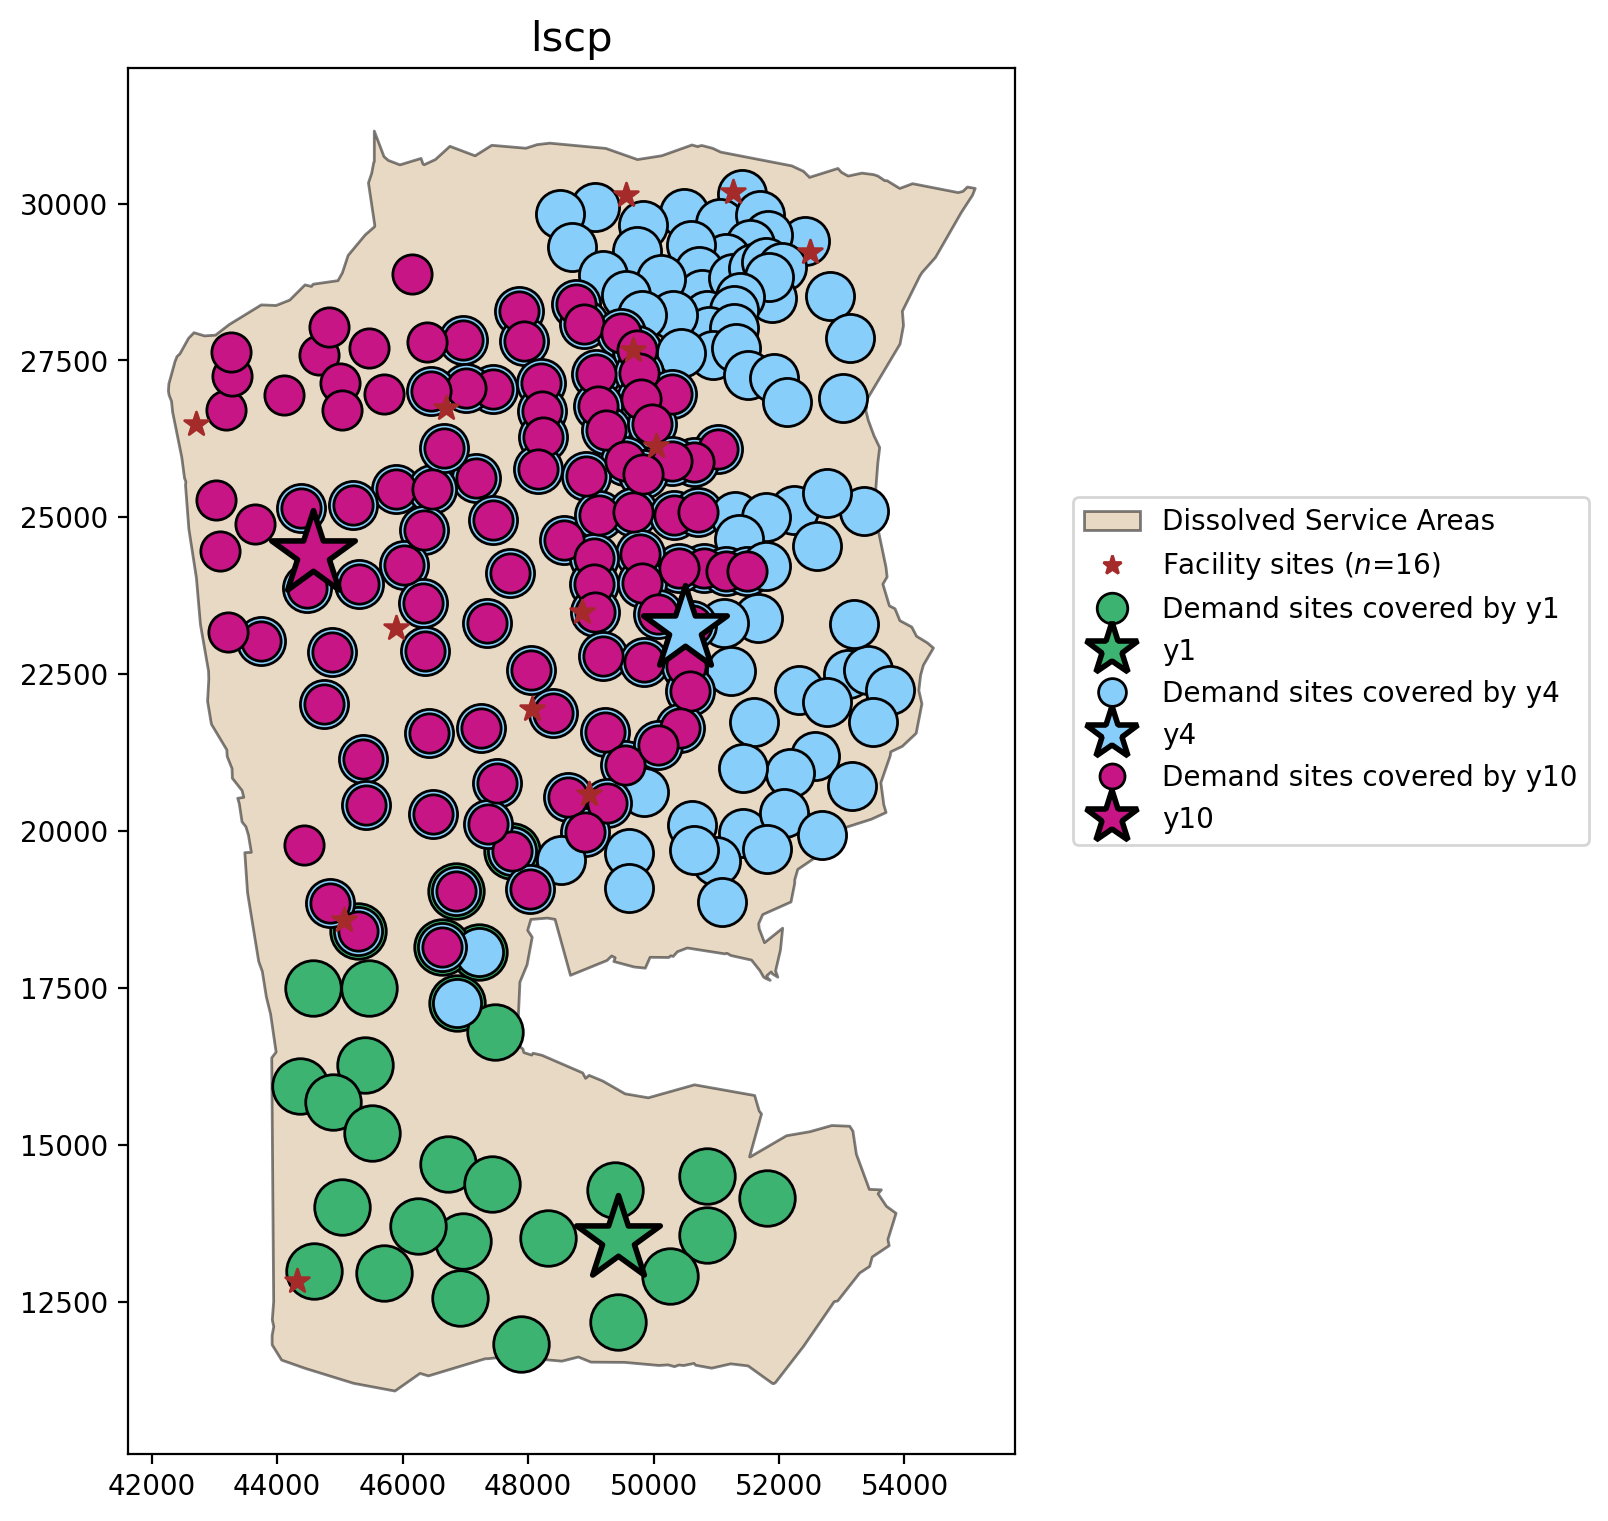

In [28]:
plot_results(lscp, lscp_obj, facility_points, clis=demand_points)

## LSCP-B considering all candidate facilities

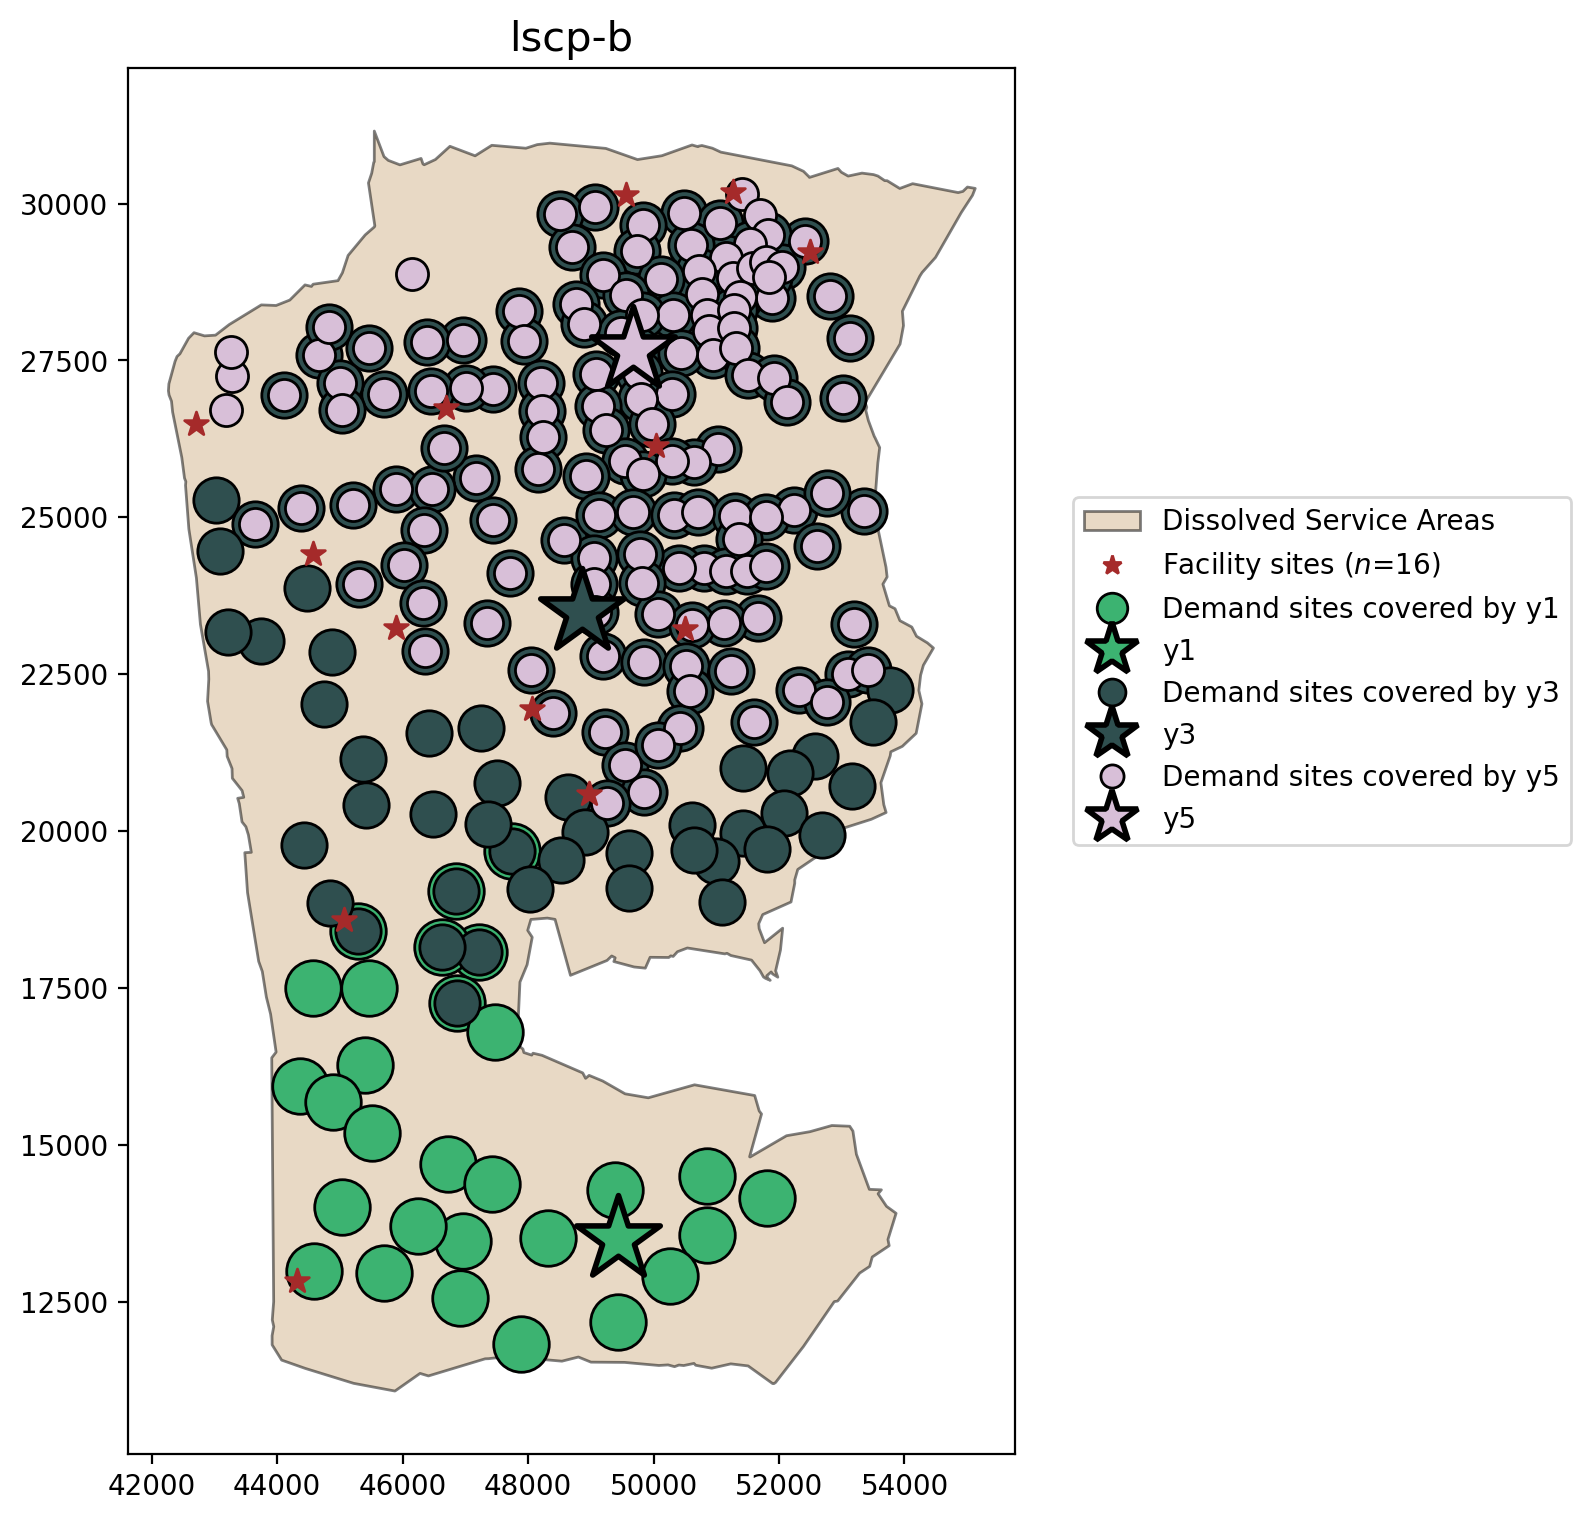

In [29]:
plot_results(lscpb, lscpb.lscp_obj_value, facility_points, clis=demand_points)

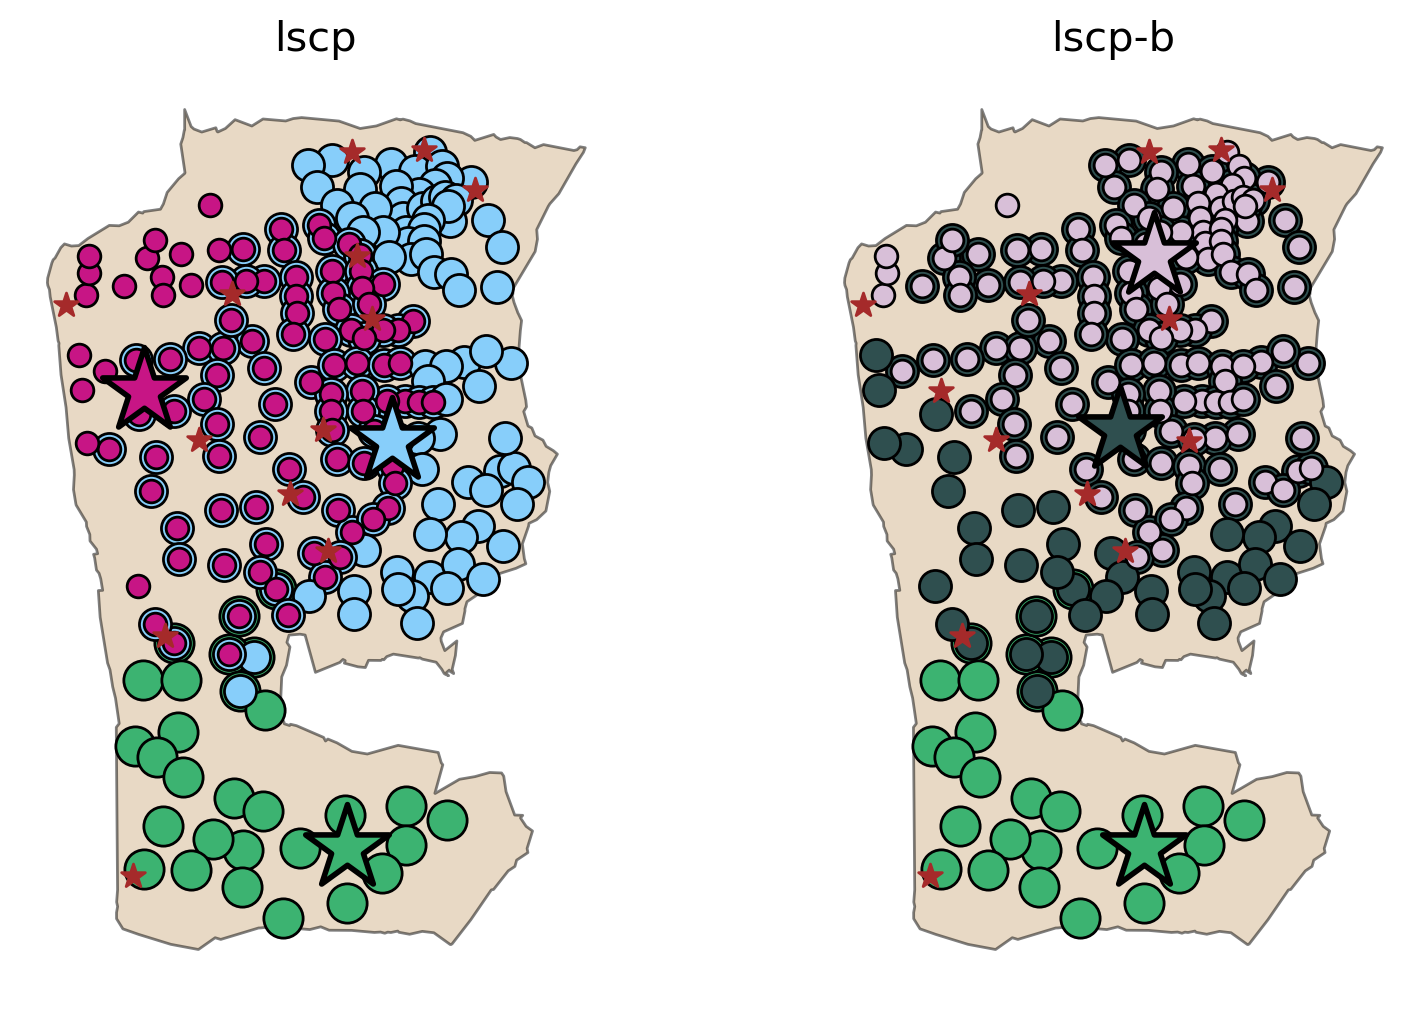

In [30]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=-0.25)
for i, m in enumerate([lscp, lscpb]):
    _p = (
        m.lscp_obj_value if m.name.startswith("lscp-b") else m.problem.objective.value()
    )
    plot_results(m, _p, facility_points, clis=demand_points, ax=axarr[i])

In both the LSCP and LSCP-B solutions facility $y_1$ is included. However, $y_4$ and $y_{10}$ in the LSCP solution are swapped out for $y_3$ and $y_5$ in the LSCP-B solution to maximize backup coverage.

---------

## LSCP with selection of predefined candidate facilities

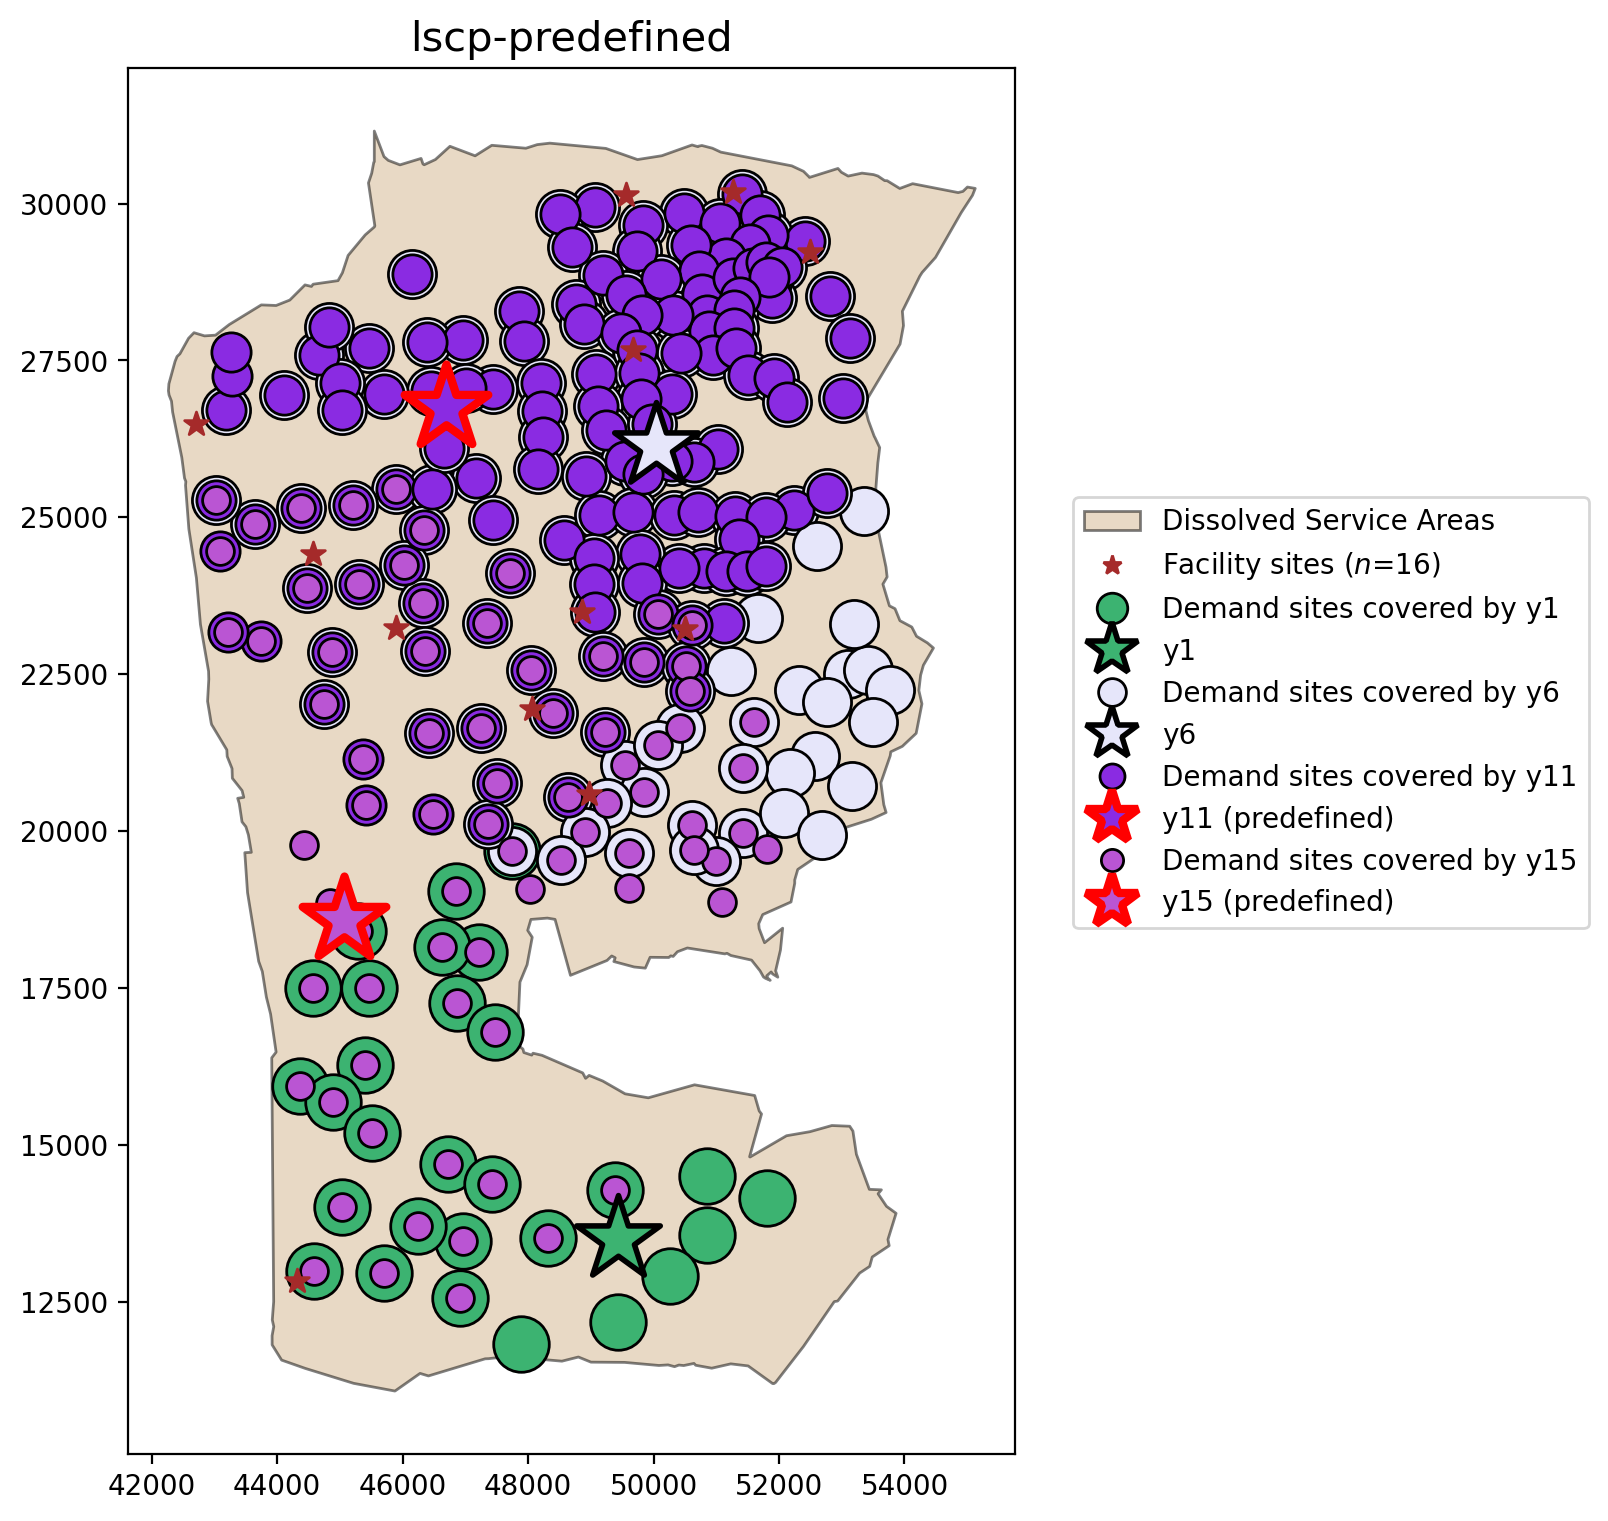

In [31]:
plot_results(
    lscp_pre,
    lscp_pre.problem.objective.value(),
    facility_points,
    clis=demand_points,
)

## LSCP-B with selection of predefined candidate facilities

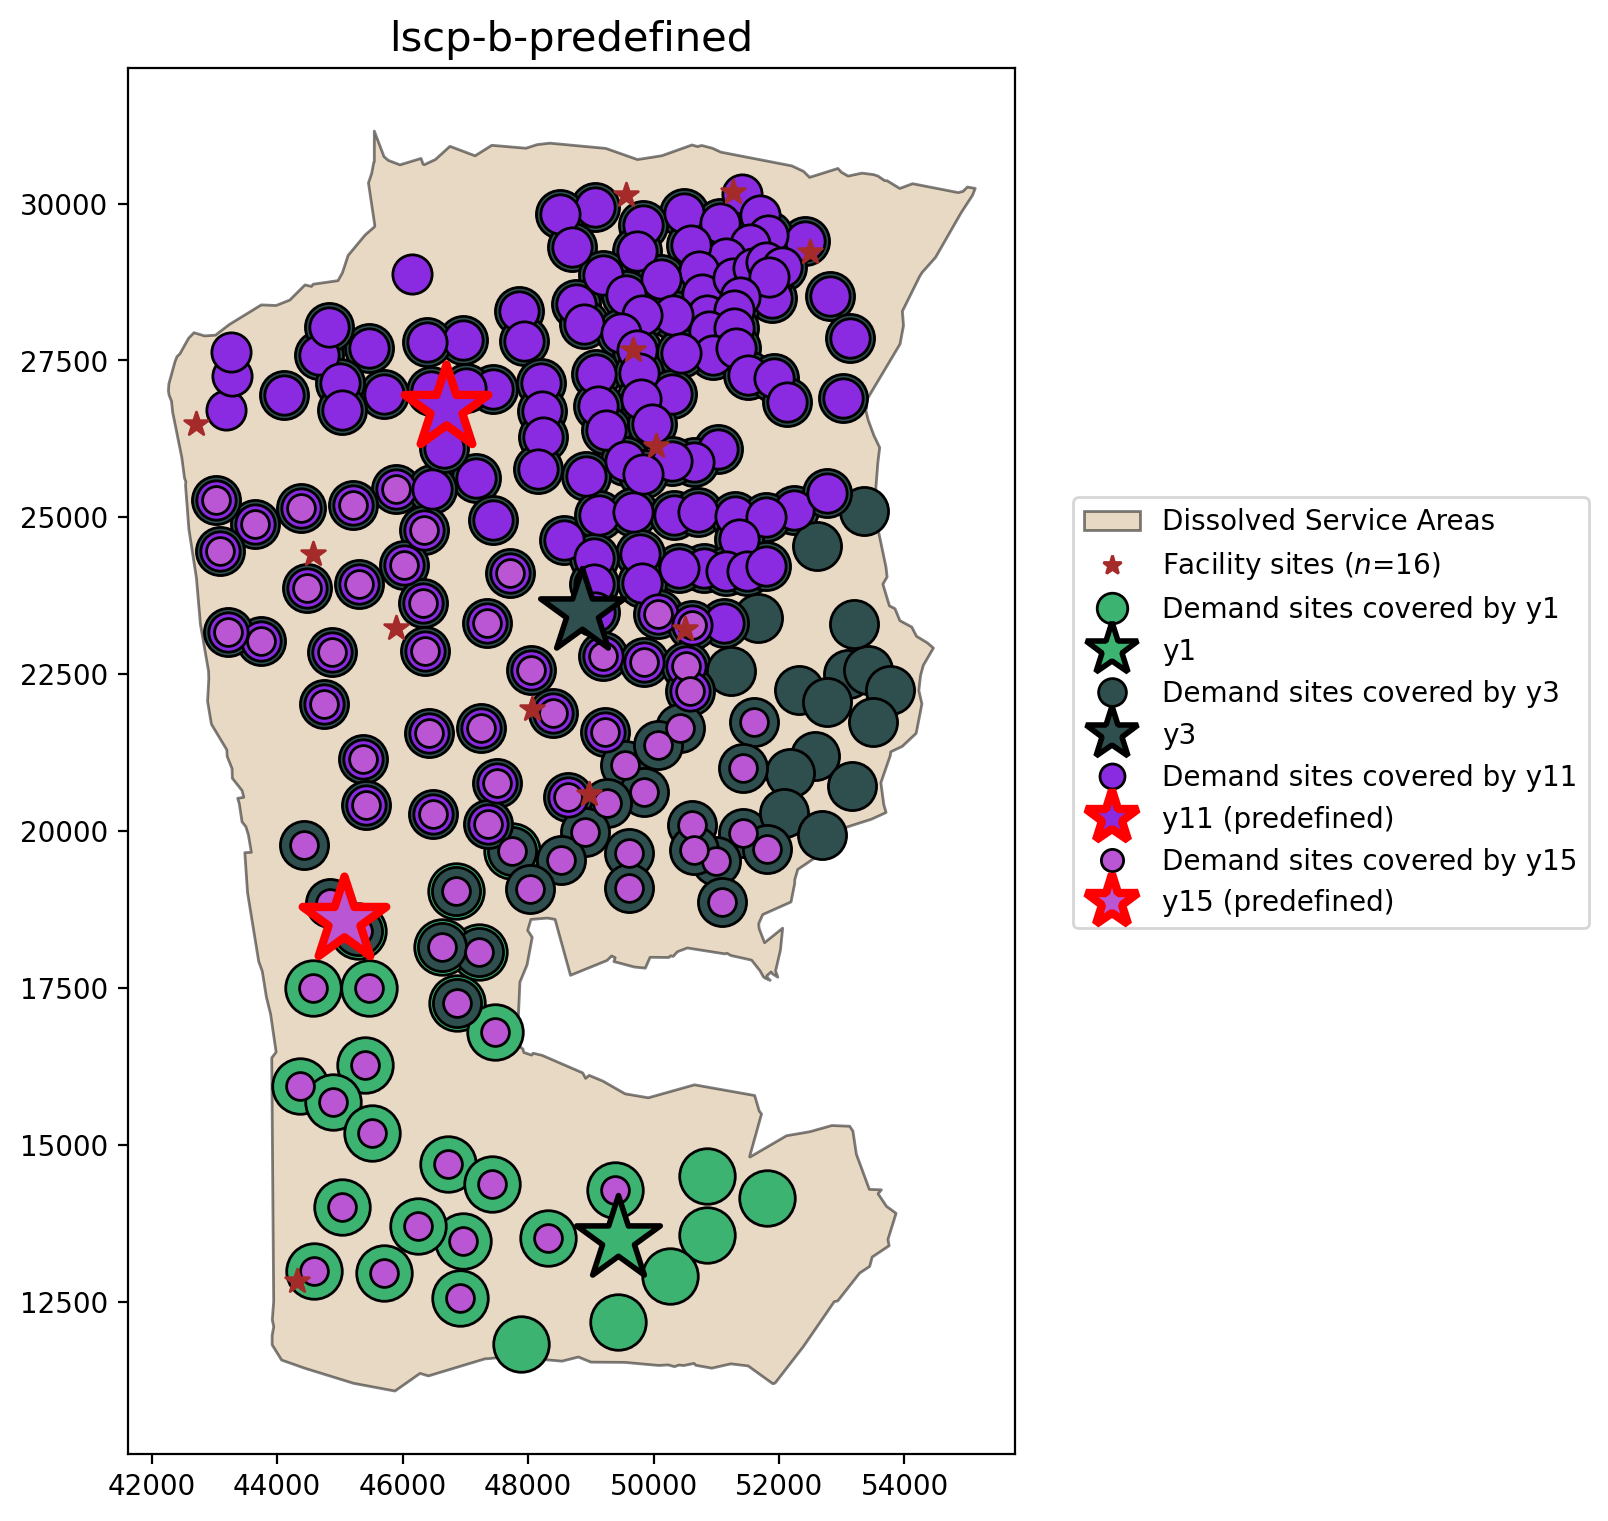

In [32]:
plot_results(lscpb_pre, lscpb_pre.lscp_obj_value, facility_points, clis=demand_points)

-----------------------------------

## Comparing all models

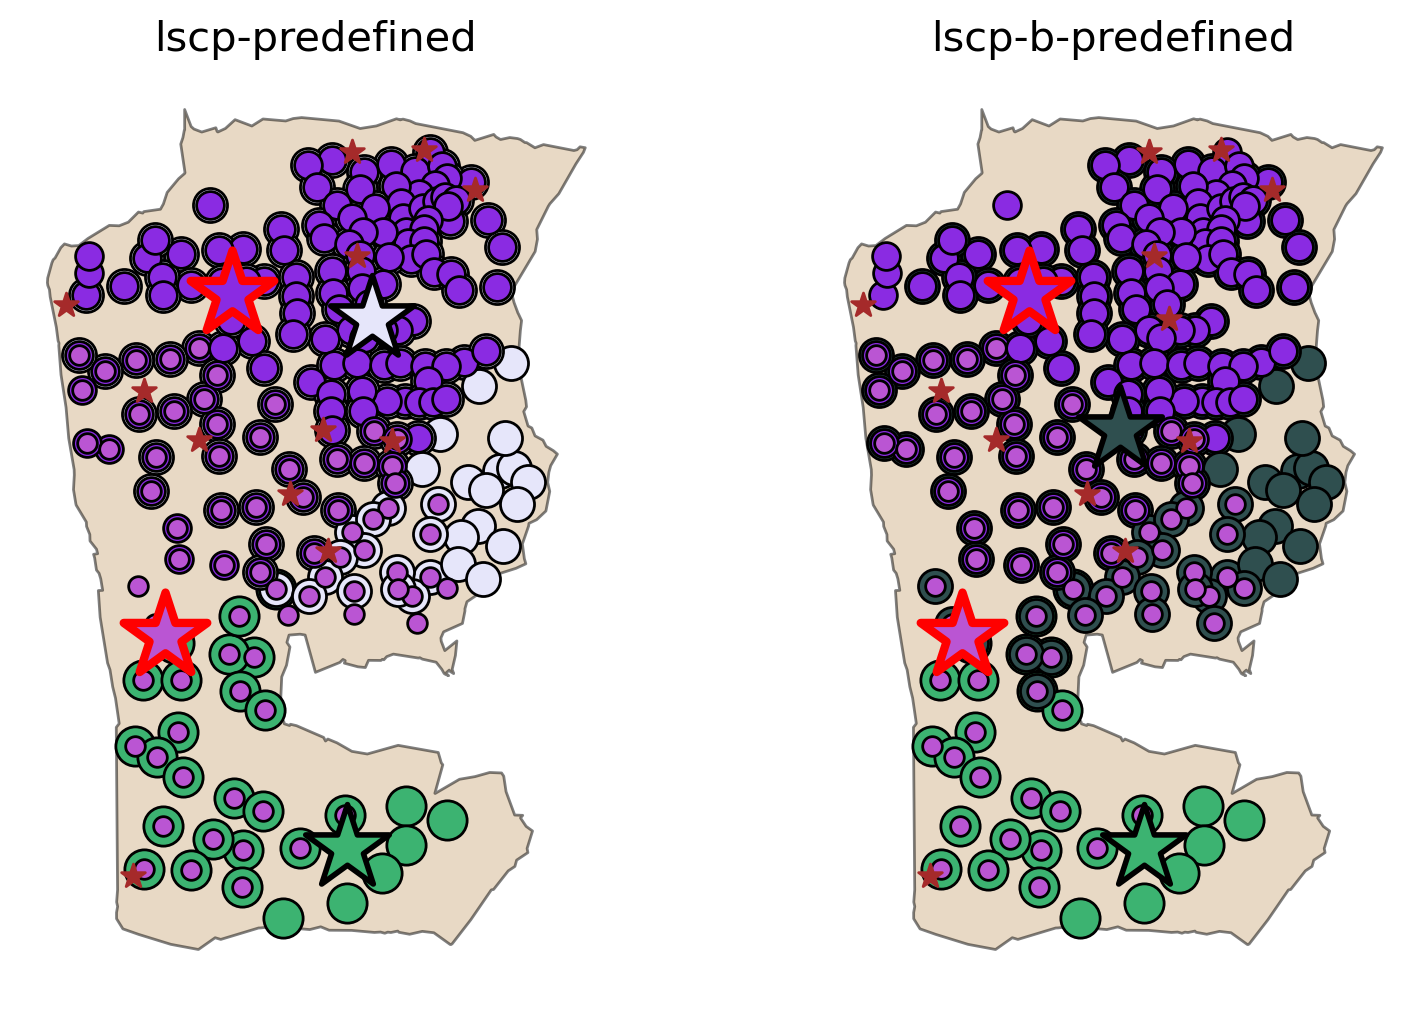

In [33]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=-0.25)
for i, m in enumerate([lscp_pre, lscpb_pre]):
    _p = (
        m.lscp_obj_value if m.name.startswith("lscp-b") else m.problem.objective.value()
    )
    plot_results(m, _p, facility_points, clis=demand_points, ax=axarr[i])

When stipulating that $y_{11}$ and $y_{15}$ must be included in the solution, the minimum number of facilities increases to 4, but as a result backup coverage also increases. Here we can see that facility $y_1$ is again present in both solutions, where the LSCP opts for $y_6$ and the LSCP-B opts for $y_3$.

----------------------------------------

## Evaluating available solvers

First we'll determine which solvers are installed locally.

In [34]:
with warnings.catch_warnings(record=True) as w:
    solvers = pulp.listSolvers(onlyAvailable=True)
for _w in w:
    print(_w.message)
solvers

GUROBI error: 
Failed to set up a license

Error 10009: License expired 2022-08-07


.


['GLPK_CMD', 'CPLEX_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'SCIP_CMD', 'HiGHS_CMD']

Above we can see that it returns a list with different solvers that are available. So, it's up to the user to choose the best solver that fits the model. Let's get the percentage as a metric to evaluate which solver is the best or improves the model.

In [35]:
results = pandas.DataFrame(
    columns=["Solution Facilities", "Backup %", "Solve Time (sec.)"], index=solvers
)
for solver in solvers:
    _solver = pulp.get_solver(solver, msg=False)
    if _solver.name == "HiGHS_CMD":
        # HiGHS doesn't directly support maximization
        with warnings.catch_warnings(record=True) as w:
            lscpb = LSCPB.from_cost_matrix(cost_matrix, SERVICE_RADIUS, _solver).solve()
        print(w[0].message)
    else:
        lscpb = LSCPB.from_cost_matrix(cost_matrix, SERVICE_RADIUS, _solver).solve()
    lscpb_perc = round(
        (lscpb.problem.objective.value() / len(lscpb.cli_vars)) * 100.0, 3
    )
    results.loc[solver] = [lscpb.lscp_obj_value, lscpb_perc, lscpb.problem.solutionTime]
results

HiGHS_CMD does not currently allow maximization, we will minimize the inverse of the objective function.


,Solution Facilities,Backup %,Solve Time (sec.)
GLPK_CMD,3,69.756,0.030007
CPLEX_CMD,3.0,69.756,0.049173
PULP_CBC_CMD,3.0,69.756,0.03828
COIN_CMD,3.0,69.756,0.046395
SCIP_CMD,3.0,69.756,0.05283
HiGHS_CMD,3.0,69.756,0.039276


--------------